In [ ]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

repo_path = os.path.abspath("..")
if repo_path not in sys.path:
    sys.path.append(repo_path)
    sys.path.append(os.path.join(repo_path, "src"))

print(f"Project Root: {repo_path}")

Project Root: /Users/alex/Desktop/inverse-iv-surface-pinn


In [ ]:
from model import IVSurfaceMLP, IVSurfaceModelConfig
from train import TrainingConfig, build_dataset_from_df
from evaluate import calculate_metrics, quantify_arbitrage_violations
from visualize import plot_market_vs_model_smile, plot_volatility_surface_3d
from data_loader import load_raw_data, get_spot_price, prepare_option_data
from preprocessing import clean_data, compute_implied_volatilities, add_additional_features

In [ ]:
TICKER = "SPY"
DATE = "2023-01-03"
RAW_DATA_PATH = os.path.join(repo_path, "data", "raw")
CHECKPOINT_PATH = os.path.join(repo_path, "models", f"{TICKER}_{DATE.replace('-', '')}_pinn.pt") # 确保文件名匹配

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Checkpoint path: {CHECKPOINT_PATH}")

Using device: cpu
Checkpoint path: /Users/alex/Desktop/inverse-iv-surface-pinn/models/SPY_20230103_pinn.pt


In [ ]:
print(f"Loading raw data for {TICKER} on {DATE}...")

try:
    raw_data = load_raw_data(RAW_DATA_PATH, TICKER, DATE)
    
    if 'option_price' not in raw_data or 'security_price' not in raw_data:
        raise FileNotFoundError("Required data (option_price or security_price) not found.")

    spot_price = get_spot_price(raw_data['security_price'])
    zero_curve = raw_data.get('zero_curve', pd.DataFrame())
    distr_proj = raw_data.get('distr_proj', None)

    print(f"Spot Price: {spot_price:.2f}")

    print("Preprocessing option data (Phase 1)...")
    df_initial = prepare_option_data(
        raw_data['option_price'],
        spot_price,
        DATE,
        zero_curve,
        distr_proj
    )
    print(f"Initial samples: {len(df_initial)}")
    
except Exception as e:
    print(f"Error in loading phase: {e}")
    raise e

Loading raw data for SPY on 2023-01-03...
Spot Price: 380.82
Preprocessing option data (Phase 1)...
Initial samples: 7470


In [ ]:
print("Preprocessing option data (Phase 2 - Advanced Cleaning)...")

df_clean = clean_data(df_initial)
print(f"Samples after cleaning: {len(df_clean)}")

if 'computed_iv' not in df_clean.columns:
    if 'impl_volatility' in df_clean.columns:
        print("Using existing 'impl_volatility' column.")
        df_clean['computed_iv'] = df_clean['impl_volatility']
    else:
        print("Computing Implied Volatilities (Brent's method)... this may take a while.")
        df_clean = compute_implied_volatilities(df_clean)
        print(f"Samples after IV computation: {len(df_clean)}")
else:
    print("Using existing 'computed_iv' column.")

df_processed = add_additional_features(df_clean)

print("Ensuring numeric types for Tensor conversion...")

input_cols = ['log_moneyness', 'T']

for col in input_cols:
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').astype(np.float32)

df_processed['mid_price'] = df_processed['mid_price'].astype(np.float32)

df_processed = df_processed.dropna(subset=input_cols + ['mid_price'])

print(f"Final ready samples: {len(df_processed)}")
df_processed.head()

Preprocessing option data (Phase 2 - Advanced Cleaning)...
Samples after cleaning: 4253
Using existing 'impl_volatility' column.
Ensuring numeric types for Tensor conversion...
Final ready samples: 4253


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,q,moneyness,log_moneyness,computed_iv,forward_moneyness,sqrt_T,log_T,is_atm,is_otm,is_itm
0,109820.0,2023-01-03,SPY 230120P410000,1,2023-01-20,2023-01-03,P,410000.0,28.8,29.06,...,0.0,1.076624,0.073830,<NA>,1.0746,0.215813,-3.066684,0,0,1
1,109820.0,2023-01-03,SPY 230120P411000,1,2023-01-20,2023-01-03,P,411000.0,29.8,30.06,...,0.0,1.07925,0.076266,<NA>,1.077221,0.215813,-3.066684,0,0,1
2,109820.0,2023-01-03,SPY 230120P412000,1,2023-01-20,2022-12-30,P,412000.0,30.8,31.06,...,0.0,1.081876,0.078697,<NA>,1.079842,0.215813,-3.066684,0,0,1
3,109820.0,2023-01-03,SPY 230120P413000,1,2023-01-20,2023-01-03,P,413000.0,31.8,32.06,...,0.0,1.084502,0.081121,<NA>,1.082463,0.215813,-3.066684,0,0,1
4,109820.0,2023-01-03,SPY 230120P414000,1,2023-01-20,2022-12-29,P,414000.0,32.8,33.06,...,0.0,1.087128,0.083539,<NA>,1.085084,0.215813,-3.066684,0,0,1


In [ ]:
config = TrainingConfig()
config.input_cols = ['log_moneyness', 'T'] 
config.target_col = 'mid_price'

print("Building DataLoader...")
test_ds = build_dataset_from_df(df_processed, config)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)
print("DataLoader ready.")

Building DataLoader...
DataLoader ready.


In [ ]:
print(f"Loading model from {CHECKPOINT_PATH}...")

try:
    model_cfg = IVSurfaceModelConfig(
        input_dim=2,
        hidden_dims=(128, 128, 64),
        activation="silu",
        output_activation="softplus",
        dropout=0.05
    )
    
    model = IVSurfaceMLP(model_cfg).to(DEVICE)
    
    state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully.")
    
except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {CHECKPOINT_PATH}")
except RuntimeError as e:
    print(f"Model Structure Error: {e}")
    print("Tip: Please verify 'hidden_dims' and 'dropout' match exactly with training_experiments.ipynb.")
except Exception as e:
    print(f"Error loading model: {e}")

Loading model from /Users/alex/Desktop/inverse-iv-surface-pinn/models/SPY_20230103_pinn.pt...
Model loaded successfully.


In [ ]:
try:
    dummy_batch = next(iter(test_loader))
    print("Batch type:", type(dummy_batch))
    if isinstance(dummy_batch, dict):
        print("Batch keys:", dummy_batch.keys())
    elif isinstance(dummy_batch, (list, tuple)):
        print("Batch is a list/tuple with length:", len(dummy_batch))
    else:
        print("Batch content:", dummy_batch)
except Exception as e:
    print("Debug failed:", e)

Batch type: <class 'dict'>
Batch keys: dict_keys(['x', 'price', 'K', 'T', 'r', 'q', 'cp', 'S'])


In [ ]:
from black_scholes import bs_price 
import numpy as np
import torch

def robust_calculate_metrics(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, dict):
                features = batch.get('features') or batch.get('x')
                
                prices = batch.get('prices') or batch.get('y') or batch.get('mid_price') or batch.get('price')
                
                S = batch.get('spots') or batch.get('S')
                K = batch.get('strikes') or batch.get('K')
                T = batch.get('maturities') or batch.get('T')
                r = batch.get('rates') or batch.get('r')
                q = batch.get('dividends') or batch.get('q')
                
                flags = batch.get('cp_flags') or batch.get('option_type') or batch.get('cp')
                
            elif isinstance(batch, (list, tuple)):
                features = batch[0]
                prices = batch[1]
                return {"Error": "Dataset returns tuple/list. Please modify IVPriceDataset to return a dict."}
            
            if prices is None:
                return {"Error": f"Could not find price key in batch. Available keys: {list(batch.keys())}"}

            features = features.to(device)
            prices = prices.to(device)
            
            iv_pred = model(features).flatten()
            
            if isinstance(batch, dict) and S is not None:
                S = S.to(device)
                K = K.to(device)
                T = T.to(device)
                r = r.to(device)
                q = q.to(device)
                flags = flags.to(device)
                
                pred_prices = bs_price(spot=S, strike=K, time_to_maturity=T, rate=r, dividend=q, sigma=iv_pred, option_type=flags)
            else:
                continue

            y_true.extend(prices.cpu().numpy())
            y_pred.extend(pred_prices.cpu().numpy())
            
    if len(y_true) == 0:
        return {"RMSE": 0.0, "MAE": 0.0, "MAPE": 0.0}

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

print("=== Quantitative Evaluation ===")
try:
    metrics = robust_calculate_metrics(model, test_loader, DEVICE)
    if "Error" in metrics:
        print(metrics["Error"])
    else:
        print(f"{'Metric':<10} | {'Value':<10}")
        print("-" * 25)
        print(f"{'RMSE':<10} | {metrics['RMSE']:.4f}")
        print(f"{'MAE':<10} | {metrics['MAE']:.4f}")
        print(f"{'MAPE':<10} | {metrics['MAPE']:.2f}%")
except Exception as e:
    print(f"Evaluation failed: {e}")
    import traceback
    traceback.print_exc()

=== Quantitative Evaluation ===
Metric     | Value     
-------------------------
RMSE       | 1.7648
MAE        | 1.2319
MAPE       | 27.41%


In [ ]:
print("=== Arbitrage Violation Check ===")

def check_calendar_arbitrage_local(model, device, grid_size=50):
    model.eval()

    k_space = torch.linspace(-0.3, 0.3, grid_size, device=device)
    t_space = torch.linspace(0.1, 2.0, grid_size, device=device)

    k_grid, t_grid = torch.meshgrid(k_space, t_space, indexing='ij')
    
    inputs = torch.stack([k_grid.flatten(), t_grid.flatten()], dim=1)
    inputs.requires_grad = True
    
    sigma = model(inputs).flatten()
    
    T_val = inputs[:, 1]
    w = (sigma ** 2) * T_val
    
    grads = torch.autograd.grad(
        outputs=w.sum(), 
        inputs=inputs, 
        create_graph=False,
        retain_graph=False
    )[0]
    
    dw_dT = grads[:, 1]
    
    violations = (dw_dT < -1e-4).sum().item()
    total_points = inputs.shape[0]
    
    return violations / total_points

try:
    ratio = check_calendar_arbitrage_local(model, DEVICE)
    print(f"Calendar Arbitrage Violation Ratio: {ratio * 100:.2f}%")
    if ratio < 0.05:
        print("Result: Excellent! The surface is mostly arbitrage-free.")
    else:
        print("Result: Warning. There are some arbitrage violations.")
        
except Exception as e:
    print(f"Arbitrage check failed: {e}")
    import traceback
    traceback.print_exc()

=== Arbitrage Violation Check ===
Calendar Arbitrage Violation Ratio: 0.00%
Result: Excellent! The surface is mostly arbitrage-free.


=== Visualizing Smile Curve ===
Plotting Smile for T = 0.2384 years (approx 87.0 days)


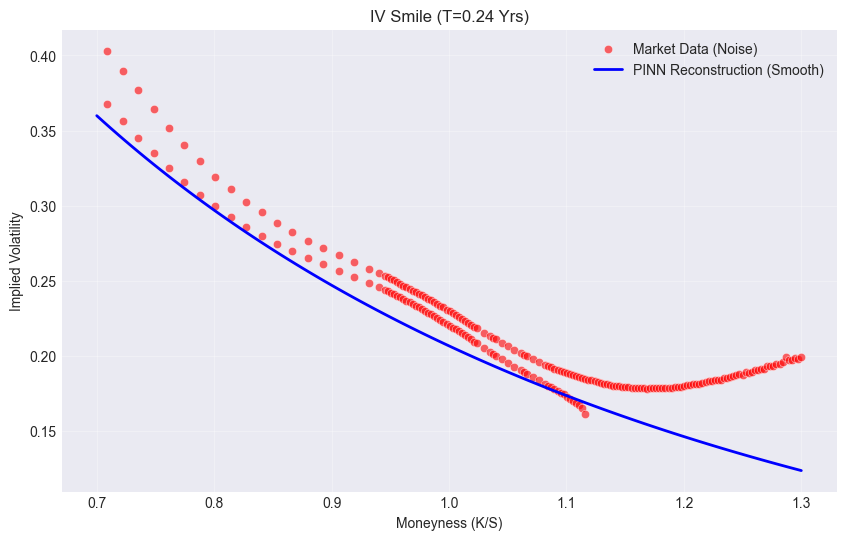

In [ ]:
print("=== Visualizing Smile Curve ===")

available_Ts = df_processed['T'].unique()
available_Ts.sort()

if len(available_Ts) > 0:
    target_T = available_Ts[len(available_Ts) // 2]
    print(f"Plotting Smile for T = {target_T:.4f} years (approx {(target_T*365):.1f} days)")
    
    try:
        fig = plot_market_vs_model_smile(df_processed, model, DEVICE, target_T=target_T)
        plt.show()
    except Exception as e:
        print(f"Plotting failed: {e}")
else:
    print("No valid maturities found in dataset.")

=== Visualizing 3D Surface ===


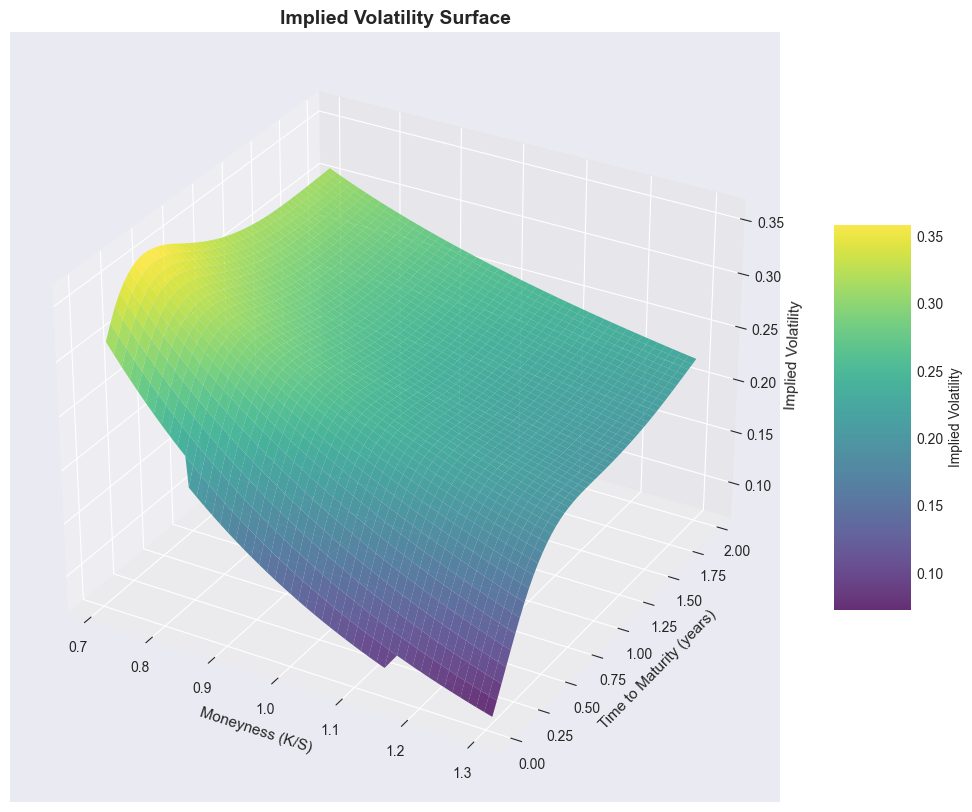

In [ ]:
print("=== Visualizing 3D Surface ===")

try:
    sample_df = df_processed.sample(min(2000, len(df_processed))).copy()

    x_input = torch.tensor(sample_df[['log_moneyness', 'T']].values, dtype=torch.float32).to(DEVICE)
    
    with torch.no_grad():
        sample_df['sigma_pred'] = model(x_input).cpu().numpy().flatten()

    fig = plot_volatility_surface_3d(sample_df, iv_col='sigma_pred')
    plt.show()
    
except Exception as e:
    print(f"3D Plotting failed: {e}")